In [72]:
# expected directory structure:
#./
#  visda_cnn.ipynb (current notebook)
#  create_mappings.ipynb (to create mappings for splits)
#  train/ (this folder is directly downloaded from https://github.com/VisionLearningGroup/taskcv-2017-public/tree/master/classification, corresponding to its train folder)   
#  mappings/ (generated by load_visda.ipynb)
#    train/
#      cyaw10.txt (list of png image paths with cyaw angle=10)
#      ...
#      cyaw333.txt
#    test/
#      cyaw10.txt
#      ...
#      cyaw333.txt
#    all/
#      cyaw10.txt (list of all png image paths with cyaw angle=10, unshuffled)
#      ...
#      cyaw333.txt

# total 20 "groups", with camera yaw angles from 10 to 333 degrees
# each group has ~7500 samples, split 80-20 into train/test
# each group does not have equal distr of all classes (e.g. more aeroplanes), but ratio consistent across rotation

In [231]:
# visualize example:
import cv2
from matplotlib import pyplot as plt
import numpy as np

def view_object_allangles(idx):
    f, axarr = plt.subplots(4, 5,figsize=(12,4))
    angles = np.arange(10,350,17)
    for i in range(20):
        listf = open(f"mappings/all/cyaw{angles[i]}.txt","r")
        img_path = listf.read().splitlines()[idx]
        curimg = cv2.imread(img_path)
        listf.close()
        axarr[int(i/5),i%5].imshow(curimg)
        axarr[int(i/5),i%5].set_title("angle %s" % angles[i])
        axarr[int(i/5),i%5].axis('off')
    plt.suptitle("Gradual shift of camera yaw angle")
    plt.show()

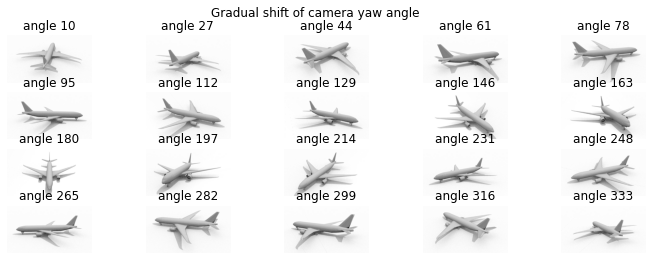

In [232]:
view_object_allangles(20)

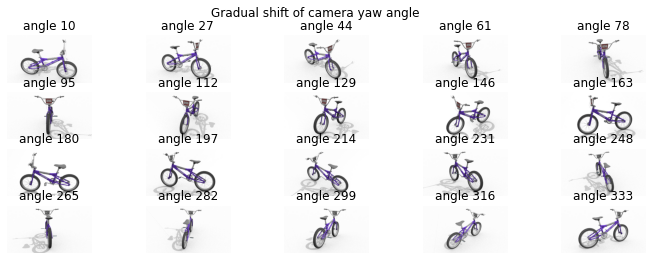

In [235]:
view_object_allangles(1000)

Train a model on source (angle=10) and evaluate on all angles

In [ ]:
import torch
from torchvision.io import read_image
import cv2

label_dict = {"aeroplane":0,
              "bicycle":1,
              "bus":2,
              "car":3,
              "horse":4,
              "knife":5,
              "motorcycle":6,
              "person":7,
              "plant":8,
              "skateboard":9,
              "train":10,
              "truck":11}

class Dataset(torch.utils.data.Dataset):
    'Characterizes a dataset for PyTorch'
    def __init__(self, list_fnames):
        'Initialization'
        self.list_fnames = list_fnames

    def __len__(self):
        'Denotes the total number of samples'
        return len(self.list_fnames)

    def __getitem__(self, index):
        'Generates one sample of data'
        # Select sample
        fn = self.list_fnames[index]

        # Load data and get label
        
        X = cv2.imread(fn)/255
        X = np.moveaxis(X, 2, 0) # channel first
        label_str = fn.split("/")[1]
        y = label_dict[label_str]
        #y_categorical = torch.eye(12)[y]
        return X, y#y_categorical

In [73]:
import os
from torch.utils.data import DataLoader

srctrainl = open("mappings/train/cyaw10.txt","r").read().splitlines()
srctestl = open("mappings/test/cyaw10.txt","r").read().splitlines()

train_src = Dataset(srctrainl)
test_src = Dataset(srctestl)

train_src_loader = DataLoader(train_src, batch_size=64, shuffle=True)
test_src_loader = DataLoader(test_src, batch_size=64, shuffle=True)

dataloaders_list = []
angles = np.arange(10,350,17)
for angle in angles:
    flist = open(f"mappings/test/cyaw{angle}.txt","r")
    imgl = flist.read().splitlines()
    flist.close()
    dataset = Dataset(imgl)
    dloader = DataLoader(dataset, batch_size=64, shuffle=True)
    dataloaders_list.append(dloader)

In [78]:
# model
import torch
import torch.nn as nn

class CNN(torch.nn.Module):
    def __init__(self, seed):
        super(CNN, self).__init__()
        torch.manual_seed(seed)
        self.conv1 = nn.Sequential(
                    nn.Conv2d(in_channels=3,
                               out_channels=16,
                               kernel_size=5,
                               stride=1,
                               padding=2,),
                    nn.ReLU(),
                    nn.MaxPool2d(kernel_size=2),
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(16,32,5,1,2),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.out = nn.Linear(32*72*72, 12)
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = x.view(x.size(0), -1)
        output = self.out(x)
        return output


In [115]:
import torch.optim as optim
import numpy as np

def eval_model(model, dataloader):
    n_total = 0
    n_eq = 0
    with torch.set_grad_enabled(False):
        for xbatch, ybatch in dataloader:
            outputs = model(xbatch.float())
            pred_num = outputs.argmax(dim=1)
            n_eq += torch.sum(pred_num==ybatch)
            n_total += pred_num.shape[0]
    acc = n_eq / n_total
    return acc
    
def train_model(train_loader, val_loader, n_epochs, seed=0):
    model = CNN(seed)
    model = model.float()
    optimizer = optim.Adam(model.parameters(), lr=0.01)
    criterion = nn.CrossEntropyLoss()
    for epoch in range(n_epochs):
        print(f"--------------epoch {epoch}--------------")
        with torch.set_grad_enabled(True):
            running_loss = 0
            n_batches = 0
            for xbatch, ybatch in train_loader:
                optimizer.zero_grad()
                outputs = model(xbatch.float())
                loss = criterion(outputs, ybatch)
                loss.backward()
                optimizer.step()
                running_loss += loss.item()
                n_batches += 1
                if (n_batches +1) % 10 == 0:
                    print(f"{n_batches} batches, loss {running_loss/n_batches}")
        print(f"training loss {running_loss/n_batches}")
            
        # validate
        train_acc = eval_model(model, train_loader)
        val_acc = eval_model(model, val_loader)
        print(f"train acc {train_acc}, val acc {val_acc}")
    return model


In [131]:
src_model = train_model(train_src_loader, test_src_loader, 6)

--------------epoch 0--------------
9 batches, loss 31.863789743847317
19 batches, loss 16.8792023533269
29 batches, loss 11.907480174097522
39 batches, loss 9.48994108958122
49 batches, loss 8.061658124534452
59 batches, loss 7.113615387577122
69 batches, loss 6.440068794333416
79 batches, loss 5.935064617591568
89 batches, loss 5.542164781120386
training loss 5.314979347089927
train acc 0.15074554085731506, val acc 0.1383606493473053
--------------epoch 1--------------
9 batches, loss 2.3233382436964245
19 batches, loss 2.2421217592138993
29 batches, loss 2.097411242024652
39 batches, loss 1.927161971728007
49 batches, loss 1.7423362926561006
59 batches, loss 1.5788426995277405
69 batches, loss 1.4358589584412782
79 batches, loss 1.3210271219663983
89 batches, loss 1.3296290836977156
training loss 1.410493863125642
train acc 0.11207602918148041, val acc 0.1062295064330101
--------------epoch 2--------------
9 batches, loss 2.4550432893964977
19 batches, loss 2.4543670353136564
29 bat

In [132]:
test_accs = []
angles = np.arange(10,350,17)
i = 0
for dloader in dataloaders_list:
    curacc = eval_model(src_model, dloader)
    print(f"evaled on {angles[i]} angle, acc {curacc}")
    test_accs.append(curacc)
    i += 1

evaled on 10 angle, acc 0.955409824848175
evaled on 27 angle, acc 0.37532809376716614
evaled on 44 angle, acc 0.244590163230896
evaled on 61 angle, acc 0.24081364274024963
evaled on 78 angle, acc 0.25656166672706604
evaled on 95 angle, acc 0.3326771557331085
evaled on 112 angle, acc 0.2900262475013733
evaled on 129 angle, acc 0.2788713872432709
evaled on 146 angle, acc 0.24475064873695374
evaled on 163 angle, acc 0.2933070957660675
evaled on 180 angle, acc 0.4599737524986267
evaled on 197 angle, acc 0.40288713574409485
evaled on 214 angle, acc 0.24934382736682892
evaled on 231 angle, acc 0.2296587973833084
evaled on 248 angle, acc 0.20866142213344574
evaled on 265 angle, acc 0.2593565285205841
evaled on 282 angle, acc 0.32349082827568054
evaled on 299 angle, acc 0.28383705019950867
evaled on 316 angle, acc 0.23687663674354553
evaled on 333 angle, acc 0.24967148900032043


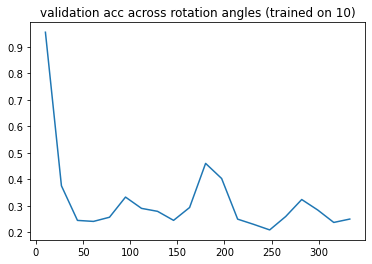

In [194]:
plt.plot(angles, test_accs)
plt.title("validation acc across rotation angles (trained on cyaw=10)")
plt.show()
# on 10-degree I am evaluating on holdout set. note at 180 degrees acc is higher bc skateboard/bus look alike when rotated 180 degrees